In [1]:
import torch
import pyro
import matplotlib.pyplot as plt
import util

device = "cuda" if torch.cuda.is_available() else "cpu"

# Generative model with true primitives

## Primitives 

In [2]:
class Square:
    def __init__(self, name, color, size):
        self.name = name
        self.color = color
        self.size = size
    
    def __repr__(self):
        return f"{self.name}(color={self.color.tolist()}, size={self.size.item():.1f})"

In [3]:
# primitives = [
#     Square("A", torch.tensor([1.0, 0.0, 0.0], device=device), torch.tensor(0.1, device=device)),
#     Square("B", torch.tensor([0.0, 1.0, 0.0], device=device), torch.tensor(0.2, device=device)),
#     Square("C", torch.tensor([0.0, 0.0, 1.0], device=device), torch.tensor(0.3, device=device))
# ]
# num_primitives = len(primitives)

## Sample the stacking program

In [4]:
def sample_stacking_program(num_primitives, device):
    # Init
    stacking_program = []
    num_sampled_primitives = 0

    # Sample first primitive
    primitive_id_logits = torch.ones((num_primitives,), device=device)
    primitive_id = pyro.sample(f"primitive_id_{num_sampled_primitives}",
                               pyro.distributions.Categorical(logits=primitive_id_logits))
    num_sampled_primitives += 1
    stacking_program.append([primitive_id])

    # Sample the rest
    end_program = False
    while not end_program:
        # Sample an action for the next primitive
        # Action 0:     put to the left of existing stack
        # Action 1:     put on existing stack 1
        # ...
        # Action N:     put on existing stack N
        # Action N + 1: put to the right of existing stack
        # Action N + 2: end program
        num_actions = len(stacking_program) + 3
        action_id_logits = torch.ones((num_actions,), device=device)
        action_id = pyro.sample(f"action_id_{num_sampled_primitives}",
                                pyro.distributions.Categorical(logits=action_id_logits))

        if action_id == len(stacking_program) + 2:
            # End program
            end_program = True
            break
        else:
            # Sample primitive
            primitive_id_logits = torch.ones((num_primitives,), device=device)
            primitive_id = pyro.sample(f"primitive_id_{num_sampled_primitives}",
                                       pyro.distributions.Categorical(logits=primitive_id_logits))
            num_sampled_primitives += 1

            # Add to the stacking program based on previous action
            if action_id == 0:
                stacking_program.insert(0, [primitive_id])
            elif action_id == len(stacking_program) + 1:
                stacking_program.append([primitive_id])
            else:
                stacking_program[action_id - 1].append(primitive_id)

    return stacking_program


def stacking_program_to_str(stacking_program, primitives):
    primitive_stacks = []
    for stack in stacking_program:
        primitive_stack = []
        for primitive_id in stack:
            primitive_stack.append(primitives[primitive_id].name)
        primitive_stacks.append(primitive_stack)
    return primitive_stacks

In [5]:
# stacking_program = sample_stacking_program(num_primitives, device)
# stacking_program

## Sample continuous locations

In [6]:
def sample_raw_locations(stacking_program):
    uniform_dist = pyro.distributions.Uniform(0, 1)
    raw_locations = []
    for stack_id, stack in enumerate(stacking_program):
        primitive_raw_locations = []
        for primitive_id, primitive in enumerate(stack):
            primitive_raw_locations.append(pyro.sample(f"stack_{stack_id}_primitive_{primitive_id}_raw_loc",
                                                       uniform_dist))
        raw_locations.append(primitive_raw_locations)
    return raw_locations

In [7]:
# raw_locations = sample_raw_locations(stacking_program)
# raw_locations

## Render stacks

### Convert from raw locations to actual locations

In [8]:
def convert_raw_locations(raw_locations, stacking_program, primitives):
    # Extract stack widths
    stack_widths = []
    for stack_id, stack in enumerate(stacking_program):
        bottom_primitive_id = stack[0]
        bottom_primitive = primitives[bottom_primitive_id]
        stack_widths.append(bottom_primitive.size)

    # Compute right limits
    right_limits = [1.0]
    for stack_width in reversed(stack_widths[1:]):
        right_limits.insert(0, right_limits[0] - stack_width)

    # Check whether limits are ok
    if stack_widths[0] > right_limits[0]:
        print("error")
    else:
        print("ok")

    # Compute bottom locations
    y = torch.tensor(-1., device=device)
    current_x = -1.0
    locations = []
    for stack_id, (stack, primitive_raw_locations, right_limit) in enumerate(
        zip(stacking_program, raw_locations, right_limits)
    ):
        # Bottom primitive
        bottom_primitive_id = stack[0]
        bottom_primitive = primitives[bottom_primitive_id]
        bottom_primitive_raw_location = primitive_raw_locations[0]

        min_x = current_x
        max_x = right_limit - bottom_primitive.size
        x = bottom_primitive_raw_location * (max_x - min_x) + min_x
        current_x = x + bottom_primitive.size
        locations.append([torch.stack([x, y])])


    # Compute the locations of the rest of the primitives
    for stack_id, (stack, primitive_raw_locations) in enumerate(zip(stacking_program, raw_locations)):
        for primitive_order, primitive_id in enumerate(stack):
            if primitive_order != 0:
                size_bottom = primitives[stack[primitive_order - 1]].size
                size = primitives[primitive_id].size
                primitive_raw_location = primitive_raw_locations[primitive_order]
                x_bottom, y_bottom = locations[stack_id][-1]
                y = y_bottom + size_bottom
                min_x = x_bottom
                max_x = x_bottom + size_bottom / 2
                x = primitive_raw_location * (max_x - min_x) + min_x
                locations[stack_id].append(torch.stack([x, y]))

    return locations

In [9]:
# locations = convert_raw_locations(raw_locations, stacking_program, primitives)

### Render primitives

In [10]:
def get_canvas_xy(num_rows, num_cols, device):
    """Create xy points on the canvas

    Args
        num_rows (int)
        num_cols (int)

    Returns
        canvas_x [num_rows, num_cols]
        canvas_y [num_rows, num_cols]
    """

    x_range = torch.linspace(-1, 1, steps=num_cols, device=device)
    y_range = torch.linspace(-1, 1, steps=num_rows, device=device).flip(dims=[0])
    # [num_cols, num_rows]
    canvas_x, canvas_y = torch.meshgrid(x_range, y_range)
    # [num_rows, num_cols]
    canvas_x, canvas_y = canvas_x.T, canvas_y.T

    return canvas_x, canvas_y


def render_square(square, location, canvas):
    """Draws a square on a canvas whose xy limits are [-1, 1].

    Args
        square
        location [2]
        canvas [num_channels, num_rows, num_cols]

    Returns
        new_canvas [num_channels, num_rows, num_cols]
    """
    # Extract
    # []
    min_x, min_y = location
    max_x = min_x + square.size
    max_y = min_y + square.size
    num_rows, num_cols = canvas.shape[-2:]
    device = location.device

    # Canvas xy
    # [num_rows, num_cols]
    canvas_x, canvas_y = get_canvas_xy(num_rows, num_cols, device)

    # Draw on canvas
    new_canvas = canvas.clone()
    for channel_id in range(num_channels):
        new_canvas[
            channel_id,
            (canvas_x >= min_x) & (canvas_x <= max_x) & (canvas_y >= min_y) & (canvas_y <= max_y)
        ] -= (1 - square.color[channel_id])
    new_canvas = new_canvas.clamp(0, 1)

    return new_canvas


def init_canvas(device, num_channels=3, num_rows=256, num_cols=256):
     return torch.ones((num_channels, num_rows, num_cols), device=device)


def render(primitives, stacking_program, raw_locations, num_channels=3, num_rows=256, num_cols=256):
    # Convert
    locations = convert_raw_locations(raw_locations, stacking_program, primitives)

    # Render
    canvas = init_canvas(device, num_channels, num_rows, num_cols)
    for stack_id, stack in enumerate(stacking_program):
        for primitive_order, primitive_id in enumerate(stack):
            primitive = primitives[primitive_id]
            location = locations[stack_id][primitive_order]
            canvas = render_square(primitive, location, canvas)

    return canvas

In [11]:
# num_channels, num_rows, num_cols = 3, 256, 256
# canvas = torch.ones((num_channels, num_rows, num_cols), device=device)

# for stack_id, stack in enumerate(stacking_program):
#     for primitive_order, primitive_id in enumerate(stack):
#         primitive = primitives[primitive_id]
#         location = locations[stack_id][primitive_order]
#         canvas = render_square(primitive, location, canvas)

# plt.imshow(canvas.cpu().permute(1, 2, 0))

## All in one

ok


[['C']]

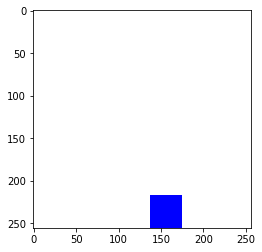

In [12]:
# Define params
primitives = [
    Square("A", torch.tensor([1.0, 0.0, 0.0], device=device), torch.tensor(0.1, device=device)),
    Square("B", torch.tensor([0.0, 1.0, 0.0], device=device), torch.tensor(0.2, device=device)),
    Square("C", torch.tensor([0.0, 0.0, 1.0], device=device), torch.tensor(0.3, device=device))
]
num_primitives = len(primitives)
num_channels, num_rows, num_cols = 3, 256, 256

# Sample
stacking_program = sample_stacking_program(num_primitives, device)
raw_locations = sample_raw_locations(stacking_program)

# Render
img = render(primitives, stacking_program, raw_locations)

# Plot
plt.imshow(img.cpu().permute(1, 2, 0))
stacking_program_to_str(stacking_program, primitives)

# Learneable square

In [13]:
import torch.nn as nn

In [198]:
class LearnableSquare(nn.Module):
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.raw_color = nn.Parameter(torch.randn((3,)))
        self.raw_size = nn.Parameter(torch.randn(()))
    
    @property
    def device(self):
        return self.raw_size.device

    @property
    def size(self):
        min_size = 0.01
        max_size = 1.0
        return self.raw_size.sigmoid() * (max_size - min_size) + min_size
    
    @property
    def color(self):
        return self.raw_color.sigmoid()
    
    def __repr__(self):
        return f"{self.name}(color={self.color.tolist()}, size={self.size.item():.1f})"

## Make an actual square we want to fit

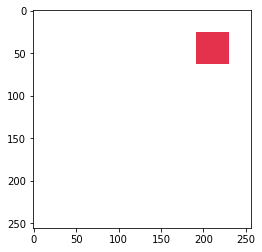

In [199]:
true_square = Square("A", torch.tensor([0.9, 0.2, 0.3], device=device), torch.tensor(0.3, device=device))
true_location = torch.tensor([0.5, 0.5], device=device)
img = render_square(true_square, true_location, init_canvas(device))
plt.imshow(img.cpu().permute(1, 2, 0))

## Soft rasterizer

In [200]:
import torch.nn.functional as F


def get_min_edge_distance(square, location, point):
    """Computes shortest distance from a point to the square edge.
    Negative if it's inside the square.
    Positive if it's outside the square.
    
    Args
        square
        location [2]
        point [*shape, 2]
    
    Returns [*shape]
    """
    # Extract
    device = location.device
    # []
    min_x, min_y = location
    max_x = min_x + square.size
    max_y = min_y + square.size
    shape = point.shape[:-1]
    # [*shape]
    x, y = point[..., 0], point[..., 1]
    
    # Determine which area the point is in
    # [*shape]
    # --High level areas
    up = (y >= max_y)
    middle = (y >= min_y) & (y < max_y)
    bottom = (y < min_y)
    left = (x < min_x)
    center = (x >= min_x) & (x < max_x)
    right = (x >= max_x)
    
    # --Use high level areas to define smaller sectors which we're going to work with
    area_1 = left & up
    area_2 = center & up
    area_3 = right & up
    area_4 = left & middle
    area_5 = center & middle
    area_6 = right & middle
    area_7 = left & bottom
    area_8 = center & bottom
    area_9 = right & bottom

    # Compute min distances
    # --Init the results
    # [*shape]
    min_edge_distance = torch.zeros_like(x)

    # --Compute distances for points in the corners (areas 1, 3, 7, 9)
    min_edge_distance[area_1] = torch.sqrt((x - min_x)**2 + (y - max_y)**2)[area_1]
    min_edge_distance[area_3] = torch.sqrt((x - max_x)**2 + (y - max_y)**2)[area_3]
    min_edge_distance[area_7] = torch.sqrt((x - min_x)**2 + (y - min_y)**2)[area_7]
    min_edge_distance[area_9] = torch.sqrt((x - max_x)**2 + (y - min_y)**2)[area_9]

    # --Compute distances for points in the outside strips (areas 2, 4, 6, 8)
    min_edge_distance[area_2] = (y - max_y)[area_2]
    min_edge_distance[area_4] = (min_x - x)[area_4]
    min_edge_distance[area_6] = (x - max_x)[area_6]
    min_edge_distance[area_8] = (min_y - y)[area_8]

    # --Compute distances for points inside the square
    min_edge_distance[area_5] = -torch.min(torch.stack([y - min_y, max_y - y, x - min_x, max_x - x]), dim=0)[0][area_5]
    
    return min_edge_distance


def get_render_log_prob(min_edge_distance, blur=1e-4):
    """
    Returns the (log) probability map used for soft rasterization as specified by
    equation (1) of
    https://openaccess.thecvf.com/content_ICCV_2019/papers/Liu_Soft_Rasterizer_A_Differentiable_Renderer_for_Image-Based_3D_Reasoning_ICCV_2019_paper.pdf
    
    Also visualized here https://www.desmos.com/calculator/5z95dy2mny
    
    Args
        min_edge_distance [*shape]
        blur [] (default 1e-4): this is the σ in equation (1)
    
    Returns [*shape]
    """
    return F.logsigmoid(-torch.sign(min_edge_distance) * min_edge_distance**2 / blur)


def soft_render_square(square, location, background, background_depth=1e-4, color_sharpness=1e-4, blur=1e-4):
    """Draws a square on a canvas whose xy limits are [-1, 1].
    
    Follows equations (2) and (3) in
    https://openaccess.thecvf.com/content_ICCV_2019/papers/Liu_Soft_Rasterizer_A_Differentiable_Renderer_for_Image-Based_3D_Reasoning_ICCV_2019_paper.pdf

    Args
        square
        location [2]
        background [num_channels, num_rows, num_cols] -- this is the background color C_b in equation (2)
        background_weight [] (default 1.): ϵ in equation (3)
        color_sharpness [] (default 1e-4): γ in equation (3)
        blur [] (default 1e-4): this is the σ in equation (1)

    Returns
        new_canvas [num_channels, num_rows, num_cols]
    """
    # Canvas xy
    # [num_rows, num_cols]
    canvas_x, canvas_y = get_canvas_xy(num_rows, num_cols, device)
    canvas_xy = torch.stack([canvas_x, canvas_y], dim=-1)

    # Get render log prob
    # --Foreground object (treat depth z = -1) [num_rows, num_cols]
    depth = 0
    square_render_log_prob = (
        get_render_log_prob(get_min_edge_distance(square, location, canvas_xy), blur=blur) +
        depth / color_sharpness
    )
    # --Background [num_rows, num_cols]
    background_render_log_prob = torch.ones_like(square_render_log_prob) * background_depth / color_sharpness

    # Compute color weight (equation (3))
    # [num_rows, num_cols]
    square_weight, background_weight = F.softmax(
        torch.stack([square_render_log_prob, background_render_log_prob]), dim=0
    )

    return square_weight[None] * square.color[:, None, None] + background_weight[None] * background

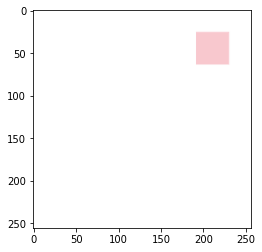

In [201]:
img = soft_render_square(true_square, true_location, init_canvas(device),
                         background_depth=1e-4, color_sharpness=1e-4, blur=1e-5)
plt.imshow(img.cpu().permute(1, 2, 0))

## Optimize learnable square

In [202]:
import itertools

In [203]:
def get_loss(location, learnable_square, background_depth, color_sharpness, blur, true_img):
    num_channels, num_rows, num_cols = img.shape
    loc = soft_render_square(learnable_square, location, init_canvas(device),
                             background_depth=background_depth,
                             color_sharpness=color_sharpness,
                             blur=blur)
    return -torch.distributions.Independent(
        torch.distributions.Normal(loc, 1.), reinterpreted_batch_ndims=3
    ).log_prob(true_img)

In [205]:
true_square = Square("A", torch.tensor([0.9, 0.2, 0.3], device=device), torch.tensor(0.3, device=device))
true_location = torch.tensor([0.5, 0.5], device=device)
true_img = render_square(true_square, true_location, init_canvas(device))

In [206]:
def optim_step(optimizer, location, learnable_square, background_depth, color_sharpness, blur, true_img):
    optimizer.zero_grad()
    loss = get_loss(location, learnable_square, background_depth, color_sharpness, blur, true_img)
    loss.backward()
    optimizer.step()
    return loss.item()

In [207]:
from tqdm import tqdm

In [208]:
def plot_iter(img, img_hard_render, true_img, losses, img_path):
    fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 1 * 4))
    axs[0].imshow(img.cpu().permute(1, 2, 0).detach().numpy())
    axs[0].set_title("Soft render")
    axs[1].imshow(img_hard_render.cpu().permute(1, 2, 0).detach().numpy())
    axs[1].set_title("Hard render")
    axs[2].imshow(true_img.cpu().permute(1, 2, 0).detach().numpy())
    axs[2].set_title("Target")
    for ax in axs[:-1]:
        ax.set_xticks([])
        ax.set_yticks([])
    axs[3].plot(losses)
    axs[3].set_title("Loss")
    axs[3].set_xlabel("Iteration")
    util.save_fig(fig, img_path)

In [209]:
# Init
learnable_square = LearnableSquare("A").to(device)
background_depth = nn.Parameter(torch.tensor(1e-4, device=device))
color_sharpness = nn.Parameter(torch.tensor(1e-4, device=device))
raw_blur = nn.Parameter(torch.randn((), device=device))
raw_location = nn.Parameter(torch.randn((2,), device=device))

optimizer = torch.optim.Adam(itertools.chain(
    learnable_square.parameters(),
    [raw_blur, raw_location]
))

# Optim
num_iterations = 20000
losses = []
img_paths = []
for iteration in tqdm(range(num_iterations)):
    location = raw_location.sigmoid() * 2 - 1
    blur = raw_blur.exp()
    losses.append(
        optim_step(optimizer, location, learnable_square, background_depth, color_sharpness, blur, true_img)
    )
    if iteration % 1000 == 0:
        img = soft_render_square(learnable_square, location, init_canvas(device),
                                 background_depth=background_depth,
                                 color_sharpness=color_sharpness,
                                 blur=blur)
        img_hard_render = render_square(learnable_square, location, init_canvas(device))
        
        # Plot
        img_paths.append(f"tmp/{iteration}.png")
        plot_iter(img, img_hard_render, true_img, losses, img_paths[-1])

  0%|          | 0/20000 [00:00<?, ?it/s]

20:59:37 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/0.png


  5%|▍         | 990/20000 [00:08<02:38, 120.02it/s]

20:59:46 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/1000.png


 10%|▉         | 1994/20000 [00:17<02:26, 123.11it/s]

20:59:55 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/2000.png


 15%|█▍        | 2996/20000 [00:26<02:17, 123.95it/s]

21:00:04 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/3000.png


 20%|█▉        | 3995/20000 [00:34<02:17, 116.31it/s]

21:00:12 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/4000.png


 25%|██▌       | 5000/20000 [00:43<02:06, 118.49it/s]

21:00:21 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/5000.png


 30%|██▉       | 5992/20000 [00:52<01:56, 120.33it/s]

21:00:30 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/6000.png


 35%|███▍      | 6993/20000 [01:01<01:49, 119.13it/s]

21:00:39 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/7000.png


 40%|███▉      | 7993/20000 [01:10<01:42, 117.71it/s]

21:00:48 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/8000.png


 45%|████▍     | 8992/20000 [01:19<01:35, 115.54it/s]

21:00:57 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/9000.png


 50%|████▉     | 9999/20000 [01:28<01:28, 113.25it/s]

21:01:06 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/10000.png


 55%|█████▍    | 10991/20000 [01:36<01:15, 118.93it/s]

21:01:14 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/11000.png


 60%|█████▉    | 11997/20000 [01:45<01:06, 120.07it/s]

21:01:23 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/12000.png


 65%|██████▌   | 13000/20000 [01:54<00:59, 116.76it/s]

21:01:32 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/13000.png


 70%|██████▉   | 13989/20000 [02:03<00:48, 123.27it/s]

21:01:40 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/14000.png


 75%|███████▌  | 15000/20000 [02:11<00:43, 114.97it/s]

21:01:49 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/15000.png


 80%|███████▉  | 15997/20000 [02:20<00:34, 114.94it/s]

21:01:58 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/16000.png


 85%|████████▍ | 16989/20000 [02:29<00:26, 115.16it/s]

21:02:07 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/17000.png


 90%|████████▉ | 17995/20000 [02:38<00:17, 115.68it/s]

21:02:16 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/18000.png


 95%|█████████▍| 18991/20000 [02:47<00:08, 120.52it/s]

21:02:25 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/19000.png


100%|██████████| 20000/20000 [02:55<00:00, 113.70it/s]


In [210]:
util.make_gif(img_paths, "training.gif", fps=3)

21:02:35 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training.gif
